# **Convolutional Neural Network - Project 1**

## **About the project:**
Given are 4750 labeled images of plant seedlings at various stages of grown of 12 different plant species as training set. The goal is to create a classifier in CNN to predict the plant species of 794 testing set images

### **Dataset Used:** Plant Seedling Images
(Source: https://www.kaggle.com/c/plant-seedlings-classification/data)

## **1. Setup Environment and Load Necessary Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2 # IMAGE PROCESSING - OPENCV
import os
import itertools
import mpl_toolkits.axes_grid1
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings("ignore")

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## **2. Data Preparation**

### Datasource downloaded from Kaggle (https://www.kaggle.com/c/plant-seedlings-classification/data) is uploaded to google drive and mounted here to access it in google colab

In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = '/content/drive/My Drive/cnn_seeds/train'
test_dir = '/content/drive/My Drive/cnn_seeds/test'

/content/drive/My Drive/Colab Notebooks/Assignments/CNN - Project 1/plant-seedlings-classification/train
/content/drive/My Drive/Colab Notebooks/Assignments/CNN - Project 1/plant-seedlings-classification/test


### **We have 12 different plant species (identified from train folder)**

In [0]:
# different species in the data set
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)

### **Number of images in each species in the training data**

In [6]:
# print number of images in each specie in the training data
for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))

263 images of Black-grass
390 images of Charlock
287 images of Cleavers
611 images of Common Chickweed
221 images of Common wheat
475 images of Fat Hen
654 images of Loose Silky-bent
221 images of Maize
516 images of Scentless Mayweed
231 images of Shepherds Purse
496 images of Small-flowered Cranesbill
385 images of Sugar beet


### **Read train and test data to dataframe**

In [59]:
# read all train data
train = []

for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])

train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('train_df.shape = ', train_df.shape)

# read all test data
test = []

for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
    
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)

train_df.shape =  (4750, 4)
test_df.shape =  (794, 2)


### **We have overall `4750` images in train data with species name and `794` images in test data without label. So, as per the objective we need to build the CNN model to predict the species name**

In [8]:
train_df.tail()

,filepath,file,species_id,species
4745,train/Sugar beet/fc293eacb.png,fc293eacb.png,11,Sugar beet
4746,train/Sugar beet/fed9406b2.png,fed9406b2.png,11,Sugar beet
4747,train/Sugar beet/fbec8cc1a.png,fbec8cc1a.png,11,Sugar beet
4748,train/Sugar beet/f8bf223f3.png,f8bf223f3.png,11,Sugar beet
4749,train/Sugar beet/ffa401155.png,ffa401155.png,11,Sugar beet


In [9]:
test_df.head()

,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png
2,test/00c47e980.png,00c47e980.png
3,test/026716f9b.png,026716f9b.png
4,test/00d090cde.png,00d090cde.png


### **Shape of first few images from train and test dataset**

In [10]:
#print the shapes of first few images from train data
print('Shapes of first few images from train data...\n')
for i in range(10):
    img = cv2.imread(os.path.join(data_dir, train_df.filepath.values[i]))
    print('{} : {}'.format(train_df.filepath.values[i], img.shape))

# #print the shapes of first few images from test data
print('\n\nShapes of first few images from test data...\n')
for i in range(10):
    img = cv2.imread(os.path.join(data_dir, test_df.filepath.values[i]))
    print('{} : {}'.format(test_df.filepath.values[i], img.shape))

Shapes of first few images from train data...

train/Black-grass/0260cffa8.png : (886, 886, 3)
train/Black-grass/078eae073.png : (1074, 1074, 3)
train/Black-grass/0ace21089.png : (1899, 1900, 3)
train/Black-grass/0bb75ded8.png : (1782, 1836, 3)
train/Black-grass/0c67c3fc3.png : (1328, 1328, 3)
train/Black-grass/0d4f74f4a.png : (1417, 1417, 3)
train/Black-grass/0e91f92a1.png : (961, 961, 3)
train/Black-grass/13a7f553a.png : (1571, 1571, 3)
train/Black-grass/14719a83e.png : (2474, 2474, 3)
train/Black-grass/1a125880e.png : (1718, 1949, 3)


Shapes of first few images from test data...

test/0021e90e4.png : (270, 270, 3)
test/003d61042.png : (253, 253, 3)
test/00c47e980.png : (313, 313, 3)
test/026716f9b.png : (231, 231, 3)
test/00d090cde.png : (283, 283, 3)
test/0086a6340.png : (214, 214, 3)
test/00ef713a8.png : (259, 259, 3)
test/007b3da8b.png : (288, 288, 3)
test/01291174f.png : (204, 204, 3)
test/02cfeb38d.png : (269, 269, 3)


### **We can see the images vary in size. However for CNN we need same dimensional images. So, we need to resize them such that each image has a standard size (Let say 100x100)**

In [0]:
# Target image size to use for resizing
target_image_size = 100

### **View first few images in each species from train dataset**

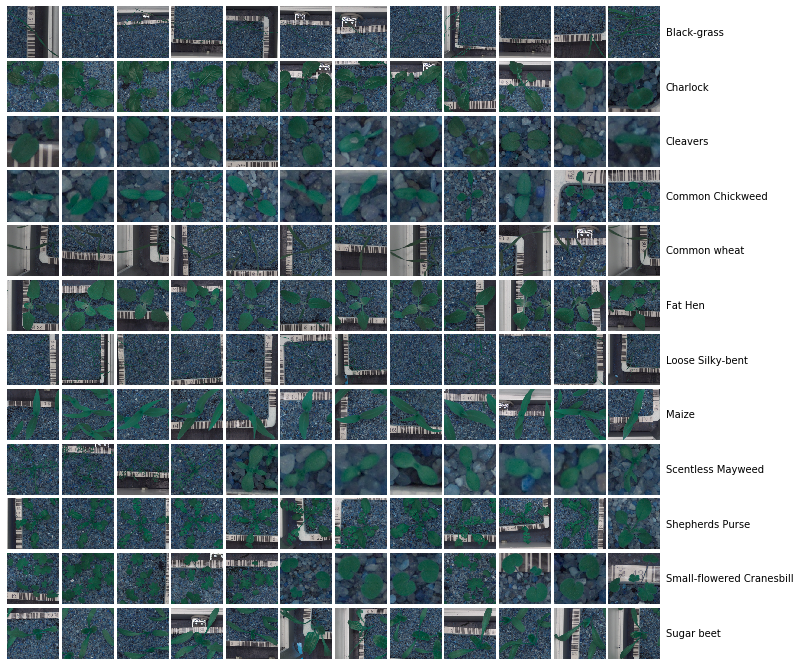

In [12]:
# function to read an image 
def read_image(filepath, target_size=None):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    return img

# Print first few images in each species
fig = plt.figure(1, figsize=(num_species, num_species))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                          axes_pad=0.05)
i = 0
for species_id, sp in enumerate(species):
    for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
        ax = grid[i]
        img = read_image(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        if i % num_species == num_species - 1:
            ax.text(250, 112, sp, verticalalignment='center')
        i += 1
plt.show();

### **View first few images from test dataset**

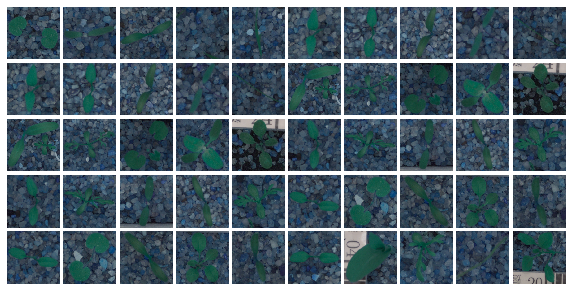

In [13]:
# Print first few images in test dataset
fig = plt.figure(1, figsize=(10, 10))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(5, 10), 
                                          axes_pad=0.05)
i = 0
for j in range(5):
    for filepath in test_df['filepath'].values[j*5:j*5+10]:
        ax = grid[i]
        img = read_image(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        i += 1
plt.show();

### Images have lot of noises, so it's important to clean the images by removing unwanted noises and the background. 
Following steps are involved in this activity

*   Convert the blurred RGB image to HSV
*   Create mask to remove the background
*   Blur the image to remove noise


In [0]:
## detect and segment plants in the image 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_segmented_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return img, image_mask, image_segmented, image_sharpen

def read_final_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return image_sharpen

### **View few images with each steps of segmentation**

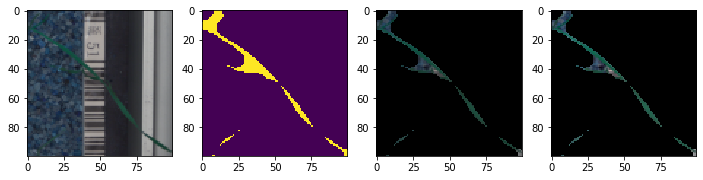

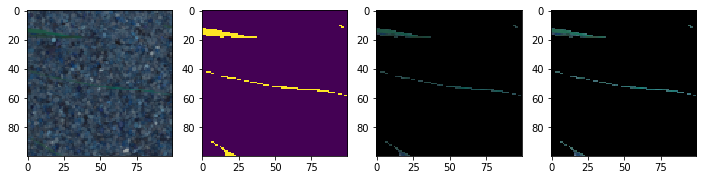

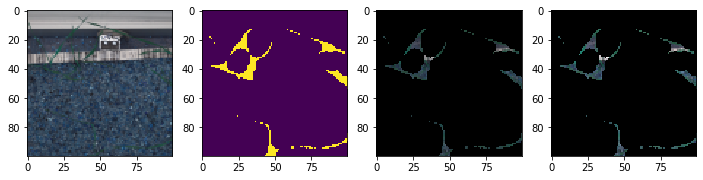

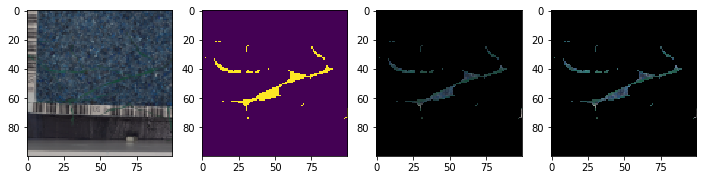

In [16]:
for i in range(4):

    img, image_mask, image_segmented, image_sharpen = read_segmented_image(train_df.loc[i,'filepath'], (target_image_size, target_image_size))
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 12))
    axs[0].imshow(img.astype(np.uint8))
    axs[1].imshow(image_mask.astype(np.uint8))
    axs[2].imshow(image_segmented.astype(np.uint8))
    axs[3].imshow(image_sharpen.astype(np.uint8))

### **Read and preprocess all training images and labels and testing images**

In [14]:
train_df.head()

,filepath,file,species_id,species
0,train/Black-grass/0260cffa8.png,0260cffa8.png,0,Black-grass
1,train/Black-grass/078eae073.png,078eae073.png,0,Black-grass
2,train/Black-grass/0ace21089.png,0ace21089.png,0,Black-grass
3,train/Black-grass/0bb75ded8.png,0bb75ded8.png,0,Black-grass
4,train/Black-grass/0c67c3fc3.png,0c67c3fc3.png,0,Black-grass


In [9]:
# read training images  
x = np.zeros((len(train_df), target_image_size, target_image_size, 3), dtype='float32')
y = train_df.loc[:, 'species_id'].values

for i, filepath in tqdm(enumerate(train_df['filepath'])):
    # segment the plant from the image
    img = read_final_image(filepath, (target_image_size, target_image_size))
    
    # read the pixel array from the image
    x[i] = np.expand_dims(img.copy().astype(np.float), axis=0)

4750it [00:52, 90.40it/s]


In [10]:
# read test images  
x_test = np.zeros((len(test_df), target_image_size, target_image_size, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test_df['filepath'])):
    # segment the plant from the image
    img = read_final_image(filepath, (target_image_size, target_image_size))
    
    # read the pixel array from the image
    x_test[i] = np.expand_dims(img.copy().astype(np.float), axis=0)

794it [00:05, 154.82it/s]


In [25]:
# Shape of the train data
print(x.shape)
# Shape of the test data
print(x_test.shape)

(4750, 100, 100, 3)
(794, 100, 100, 3)


### **Converting the Labels into one-hot vectors**

We have 12 classes of possible plant species, so let us use 12 to break it to 12 columns of one-hot vectors

In [0]:
y=np_utils.to_categorical(y, num_species)

### **Save the train and test datasets for future use** 
We can simply load the train and test datasets from saved files. This is useful when we run multiple experiments by restarting the runtime, we can skip the long running physical image to pixel arrays step

In [0]:
# features set from train data
pickle_out_x = open(os.path.join(data_dir, "x.pickle"), "wb")
pickle.dump(x, pickle_out_x)
pickle_out_x.close()

# labels set from train data
pickle_out_y = open(os.path.join(data_dir, "y.pickle"), "wb")
pickle.dump(y, pickle_out_y)
pickle_out_y.close()

# features set from test data
pickle_out_x_test = open(os.path.join(data_dir, "x_test.pickle"), "wb")
pickle.dump(x_test, pickle_out_x_test)
pickle_out_x_test.close()

### **Load the data from pickle files**
We can comment this and when required we can uncomment and run

In [0]:
# load the data from pickle files
pickle_in_x = open(os.path.join(data_dir, "x.pickle"), "rb")
x = pickle.load(pickle_in_x)

pickle_in_y = open(os.path.join(data_dir, "y.pickle"), "rb")
y = pickle.load(pickle_in_y)

pickle_in_x_test = open(os.path.join(data_dir, "x_test.pickle"), "rb")
x_test = pickle.load(pickle_in_x_test)

### **Creating Train and Validation Set**

Let us split the given training images as train and validation sets in the ratio of `90:10`

In [0]:
# Normalize the pixel values by dividing it by 255. 
# The resultant values would be between 0 and 1
x = x/255.0
x_test = x_test/255.0

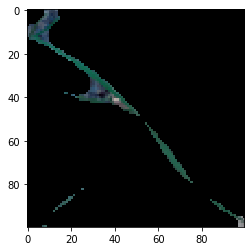

In [9]:
# Print the first image from train dataset
plt.imshow(x[0])

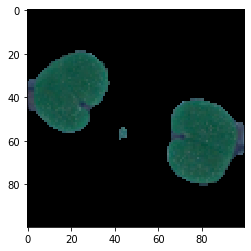

In [10]:
# Print the first image from test dataset
plt.imshow(x_test[0])

### **As the train data is read in order from the folders, let us shuffle randomly**.

In [11]:
# shuffle data
perm_array = np.arange(len(x)) 
print('Data order before shuffling')
print(perm_array)

np.random.shuffle(perm_array)
print('Data order after shuffling')
print(perm_array)

x = x[perm_array]
y = y[perm_array]

Data order before shuffling
[   0    1    2 ... 4747 4748 4749]
Data order after shuffling
[3260 1691 2059 ... 2733  547 2464]


In [0]:
# In below, valid represents validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=7)

In [13]:
x_train.shape

(3800, 100, 100, 3)

In [14]:
x_valid.shape

(950, 100, 100, 3)

## **3. Model Creation**

### **Define a Basic CNN Model**


Let us build a basic CNN model with,
* 2 convolutional layers
* 2 fully connected layers

In [0]:
np.random.seed(7)

In [16]:
# Create the model
model1 = tf.keras.models.Sequential()

# First conv. layer with 128 filters of 3x3 size
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(target_image_size, target_image_size, 3), activation='relu'))

# Second conv. layer with 128 filters of 3x3 size
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten to convert volume received from above layer to flat array 
model1.add(tf.keras.layers.Flatten())

# Fully connected dense hidden layer with 256 neurons
model1.add(tf.keras.layers.Dense(256, activation='relu'))

# Output dense layer with 12 classes 
model1.add(tf.keras.layers.Dense(num_species, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 128)       3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1179648)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               301990144 
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 302,144,396
Trainable params: 302,144,396
Non-trainable params: 0
_________________________________________________________________


## **4. Training and Evaluation**

In [17]:
# Implementing early_stopping to cut the epoch cycles if no accuracy 
# improvements when training a learner with an iterative method
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
callback_list1 = [early_stopping1]

# Fit the model
history1 = model1.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=50, callbacks=callback_list1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3800 samples, validate on 950 samples
Epoch 1/50





3800/3800 [==============================] - 38s 10ms/step - loss: 2.0460 - acc: 0.3045 - val_loss: 1.6093 - val_acc: 0.4179
Epoch 2/50
3800/3800 [==============================] - 29s 8ms/step - loss: 0.9758 - acc: 0.6679 - val_loss: 1.7232 - val_acc: 0.4284
Epoch 3/50
3800/3800 [==============================] - 29s 8ms/step - loss: 0.1585 - acc: 0.9521 - val_loss: 2.9131 - val_acc: 0.4189
Epoch 4/50
3800/3800 [==============================] - 29s 8ms/step - loss: 0.0326 - acc: 0.9905 - val_loss: 3.1579 - val_acc: 0.4295
Epoch 5/50
3800/3800 [==============================] - 29s 8ms/step - loss: 0.0094 - acc: 0.9987 - val_loss: 3.5856 - val_acc: 0.4432
Epoch 6/50
3800/3800 [==============================] - 29s 8ms/step - loss: 0.0050 - acc: 0.9989 - val_loss: 3.8177 - val_acc: 0.4305
Epoch 7/50
3800/3800 [==================

In [18]:
# Final evaluation of the model
train_scores = model1.evaluate(x_train, y_train, verbose=0)
print("Training Set Accuracy: %.2f%%" % (train_scores[1]*100))

valid_scores = model1.evaluate(x_valid, y_valid, verbose=0)
print("Validation Set Accuracy: %.2f%%" % (valid_scores[1]*100))

Training Set Accuracy: 99.92%
Validation Set Accuracy: 40.53%


### We got an accuracy of ~99% in training set whereas the validation set gives a poor accuracy of ~40% with this basic CNN model. This huge variance is because of overfitting. So, let us fine tune the model to see if we get a good accuracy on both training and validation sets

### **Fine-tuning the CNN Model**
Let us fine-tune the CNN model by,
* Adding more convolutional and fully connected layers
* Introducing pooling layers
* Introducing BatchNormalization and drop-out rate

In [19]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), input_shape=(target_image_size, target_image_size, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.1))

# Output dense layer with 12 classes
model2.add(tf.keras.layers.Dense(num_species, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0         
__

### **Prevent overfitting with Image Augmentation**
Image augmentation helps to prevent overfitting, we can use ImageDataGenerator to randomly change image characteristics during fitting

In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')
generator.fit(x_train)

In [21]:
# Implementing early_stopping to cut the epoch cycles if no accuracy 
# improvements when training a learner with an iterative method
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
callback_list2 = [early_stopping2]

# Fit the model
history2 = model2.fit_generator(generator.flow(x_train, y_train, batch_size=16), validation_data=(x_valid, y_valid), epochs=50, callbacks=callback_list2)

Epoch 1/50
238/238 [==============================] - 12s 52ms/step - loss: 1.8756 - acc: 0.3642 - val_loss: 1.3239 - val_acc: 0.5453
Epoch 2/50
238/238 [==============================] - 11s 44ms/step - loss: 1.4177 - acc: 0.5095 - val_loss: 2.3164 - val_acc: 0.3726
Epoch 3/50
238/238 [==============================] - 11s 45ms/step - loss: 1.2299 - acc: 0.5780 - val_loss: 1.8518 - val_acc: 0.4526
Epoch 4/50
238/238 [==============================] - 11s 45ms/step - loss: 1.0744 - acc: 0.6292 - val_loss: 1.4856 - val_acc: 0.5421
Epoch 5/50
238/238 [==============================] - 11s 45ms/step - loss: 0.9881 - acc: 0.6626 - val_loss: 1.2942 - val_acc: 0.6158
Epoch 6/50
238/238 [==============================] - 11s 45ms/step - loss: 0.8915 - acc: 0.6896 - val_loss: 1.1947 - val_acc: 0.5926
Epoch 7/50
238/238 [==============================] - 11s 45ms/step - loss: 0.8471 - acc: 0.7064 - val_loss: 0.7360 - val_acc: 0.7400
Epoch 8/50
238/238 [==============================] - 11s 45ms

In [22]:
# Final evaluation of the model
train_scores = model2.evaluate(x_train, y_train, verbose=0)
print("Training Set Accuracy: %.2f%%" % (train_scores[1]*100))

valid_scores = model2.evaluate(x_valid, y_valid, verbose=0)
print("Validation Set Accuracy: %.2f%%" % (valid_scores[1]*100))

Training Set Accuracy: 86.11%
Validation Set Accuracy: 86.21%


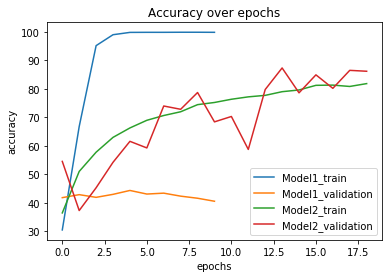

In [26]:
plt.plot(np.array(history1.history['acc']) * 100)
plt.plot(np.array(history1.history['val_acc']) * 100)
plt.plot(np.array(history2.history['acc']) * 100)
plt.plot(np.array(history2.history['val_acc']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Model1_train', 'Model1_validation', 'Model2_train', 'Model2_validation'])
plt.title('Accuracy over epochs')
plt.show()

### **Fine tuned the model by introducing image augmentation, additional convolution layers, pooling layers, dropout rate and learning rate resulted in good accuracy improvements in validation set and avoided overfitting as we can the accuracy of train and validation sets are very similar**

### **Confusion Matrix from Fine-Tuned Model**

In [0]:
# Function to display/plot the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

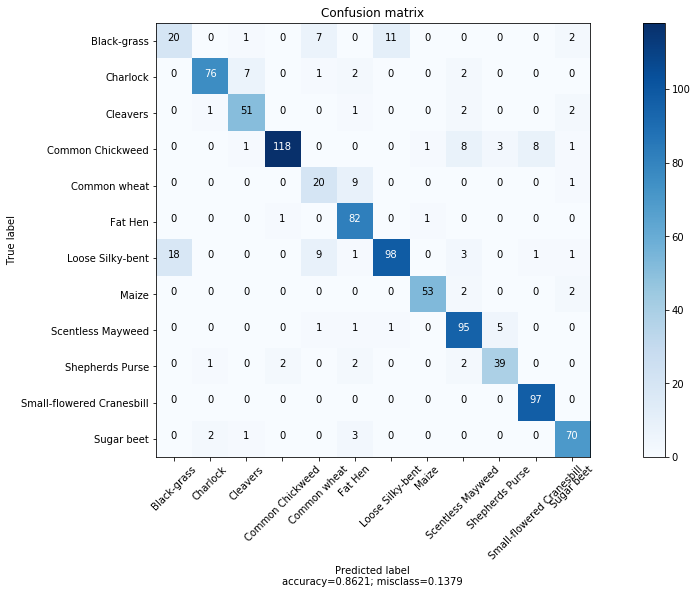

In [49]:
# Predictions
y_pred = model2.predict(x_valid)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_valid, axis = 1)
cmatrix = confusion_matrix(y_check, y_class)

# Plot confusion matrix
plot_confusion_matrix(cmatrix, species, normalize=False)

## **Predict the Test Images with Fine-Tuned Model**

In [0]:
# Predict x_test classes
test_pred = model2.predict(x_test)

# Probability to Class
test_pred_class = np.argmax(prediction_test, axis=1)

labels = preprocessing.LabelEncoder()
labels.fit(species)

# Assign it new column in test dataframe
test_pred_str = labels.classes_[test_pred_class]
test_df['Predicted_Species'] = test_pred_str

Plotting first 10 test images with their predicted label...


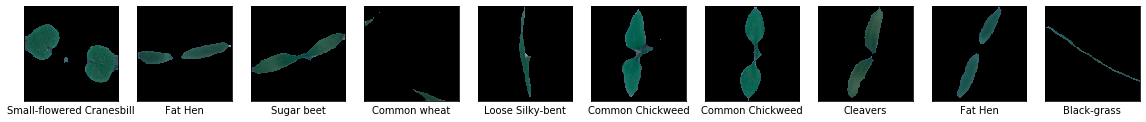

In [70]:
# Plotting first 10 test images with their predicted label
print('Plotting first 10 test images with their predicted label...')
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(str(test_df.loc[i, 'Predicted_Species']))
plt.show()

## **Insights:**
### 1. It is a challenging project for reasons, images vary in size, lot of noises in the images, imbalanced image count among plant species to train and huge time to process the images.
### 2. Hence, identified an optimal size (100x100) without losing the clarity and resized all training and testing images to that optimal size.
### 3. As noises impacts the model accuracy in great deal, implemented gaussian blur and masking to filter out only the plant seedling from the images.
### 4. The basic model has yielded good accuracy in training set whereas very poor accuracy in validation set due to overfitting.
### 5. Hence, implemented image augmentation to avoid overfitting and fine-tuned by adding more convolution layers, pooling layers, dropout rate and learning rate which yielded good accuracy on both training and validation sets